# Test the VLM endpoint

In [6]:
import base64
import cv2
import numpy as np
import pyheif
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from openai import AzureOpenAI
from pathlib import Path
import io
from PIL import Image as PIL_Image
from IPython.display import display, Image as IPython_Image

def display_image(image_path: str):
    if Path(image_path).suffix.lower() == '.heic':
        try:
            heif_file = pyheif.read(image_path)
            image = PIL_Image.frombytes(
                heif_file.mode, 
                heif_file.size, 
                heif_file.data,
                "raw",
            )
            buffer = io.BytesIO()
            image.save(buffer, format="PNG")
            display(IPython_Image(data=buffer.getvalue(), width=300))
        except Exception as e:
            print(f"Could not process HEIC file: {e}")
    else:
        display(IPython_Image(filename=image_path, width=300))


def get_all_files(directory: str) -> list[str]:
    IMAGE_EXTENSIONS = {
        '.jpg', '.jpeg', '.heic',
    }
    return [str(p) for p in Path(directory).rglob('*') if p.is_file() and p.suffix.lower() in IMAGE_EXTENSIONS]

def encode_image(image_path: str) -> str:
    global _LAST_IMAGE_PATH
    _LAST_IMAGE_PATH = image_path
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

# Function to read .HEIC image format
def read_heic_to_numpy(file_path: str):
    heif_file = pyheif.read(file_path)
    data = heif_file.data
    if heif_file.mode == "RGB":
        numpy_array = np.frombuffer(data, dtype=np.uint8).reshape(
            heif_file.size[1], heif_file.size[0], 3)
    elif heif_file.mode == "RGBA":
        numpy_array = np.frombuffer(data, dtype=np.uint8).reshape(
            heif_file.size[1], heif_file.size[0], 4)
    else:
        raise ValueError("Unsupported HEIC color mode")
    return numpy_array


endpoint = "https://oai-aip-cv-ont-sdc.openai.azure.com/"
model_name = "gpt-4o"
deployment = "gpt-4o"
token_provider = get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default")
api_version = "2024-12-01-preview"

client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=endpoint,
    azure_ad_token_provider=token_provider,
)

In [7]:
"""
Sidewalk Defects VLM + RAG

Step 1: Indexing
- Expect five grade folders `A+`, `A`, `B`, `C`, `D`
- Each folder contains:
  • one text file (any `*.txt`) with the grade description
  • a few example images (`*.jpg|*.jpeg|*.png|*.webp`)

Step 2: Retrieval
- Given a query image:
  • Embed it
  • Retrieve the most similar grade example images and grade descriptions
  • Use the retrieved grade as context for the LLM to answer: "Which score would you give to this image?"
"""

import os
import glob
from dataclasses import dataclass
from typing import List, Dict, Tuple, Any

import numpy as np
from PIL import Image

from sentence_transformers import SentenceTransformer
import faiss

# =====================
# Config
# =====================
PROJECT_ROOT = os.getcwd()
GRADES_DIR = os.path.join(PROJECT_ROOT, "data", "grades")
PREFERRED_MODEL = "jinaai/jina-clip-v2"
FALLBACK_MODEL = "clip-ViT-B-32"

# =====================
# Data classes
# =====================
@dataclass
class GradeDesc:
    grade: str
    description: str

@dataclass
class RetrievalResult:
    idx: int
    score: float
    meta: Dict[str, str]

# =====================
# Utilities
# =====================
def l2_normalize(x: np.ndarray, axis: int = -1, eps: float = 1e-12) -> np.ndarray:
    norm = np.linalg.norm(x, axis=axis, keepdims=True)
    return x / np.maximum(norm, eps)

def load_image(path: str) -> Image.Image:
    return Image.open(path).convert("RGB")

def walk_images(root: str) -> List[str]:
    exts = ("*.jpg", "*.jpeg", "*.png", "*.webp")
    paths = []
    for e in exts:
        paths.extend(glob.glob(os.path.join(root, e)))
    return sorted(paths)

# =====================
# Model
# =====================
def load_st_model() -> SentenceTransformer:
    try:
        return SentenceTransformer(PREFERRED_MODEL)
    except Exception:
        return SentenceTransformer(FALLBACK_MODEL)

class Embedder:
    def __init__(self, model: SentenceTransformer):
        self.model = model

    def embed_images(self, imgs: List[Image.Image]) -> np.ndarray:
        return self.model.encode(imgs, convert_to_numpy=True, normalize_embeddings=True).astype("float32")

    def embed_texts(self, texts: List[str]) -> np.ndarray:
        return self.model.encode(texts, convert_to_numpy=True, normalize_embeddings=True).astype("float32")

# =====================
# Index
# =====================
class FaissIndex:
    def __init__(self, dim: int):
        self.index = faiss.IndexFlatIP(dim)
        self.meta: List[Dict[str, str]] = []
        self.dim = dim

    def add(self, vecs: np.ndarray, metas: List[Dict[str, str]]):
        vecs = l2_normalize(vecs)
        self.index.add(vecs.astype("float32"))
        self.meta.extend(metas)

    def search(self, q: np.ndarray, topk: int = 5) -> List[RetrievalResult]:
        """Cosine similarity search; accepts 1D (d,) or 2D (n,d) query arrays.
        Returns empty list if index is missing or empty.
        """
        # Handle missing/empty index gracefully
        if getattr(self, "index", None) is None:
            return []
        try:
            ntotal = self.index.ntotal
        except Exception:
            ntotal = 0
        if ntotal == 0:
            return []

        # Ensure 2D shape for FAISS
        if q.ndim == 1:
            q = q[None, :]
        # Normalize (cosine via inner product)
        if not np.allclose(np.linalg.norm(q, axis=1), 1.0, atol=1e-3):
            q = l2_normalize(q)
        # Search
        scores, idxs = self.index.search(q.astype("float32"), topk)
        results: List[RetrievalResult] = []
        for i, s in zip(idxs[0], scores[0]):
            if i == -1:
                continue
            results.append(RetrievalResult(idx=int(i), score=float(s), meta=self.meta[int(i)]))
        return results

# =====================
# Grade folder loader
# =====================
def read_grade_dirs(grades_root: str) -> Tuple[List[GradeDesc], List[str], List[Dict[str, str]]]:
    grade_descs: List[GradeDesc] = []
    img_paths: List[str] = []
    img_metas: List[Dict[str, str]] = []

    for grade in sorted(os.listdir(grades_root)):
        gdir = os.path.join(grades_root, grade)
        if not os.path.isdir(gdir):
            continue
        txts = glob.glob(os.path.join(gdir, "*.txt"))
        desc = open(txts[0], "r", encoding="utf-8").read().strip() if txts else f"Grade {grade} (no description)"
        grade_descs.append(GradeDesc(grade=grade, description=desc))
        for p in walk_images(gdir):
            img_paths.append(p)
            img_metas.append({"grade": grade, "path": p})

    return grade_descs, img_paths, img_metas

# =====================
# Build indices
# =====================
def build_indices(embedder: Embedder, dim: int):
    grade_descs, img_paths, img_metas = read_grade_dirs(GRADES_DIR)
    print(grade_descs)

    # Text index
    texts = [f"Grade {g.grade}: {g.description}" for g in grade_descs]
    text_embs = embedder.embed_texts(texts)
    text_index = FaissIndex(dim)
    text_index.add(text_embs, [{"grade": g.grade, "text": g.description} for g in grade_descs])

    # Image index
    imgs = [load_image(p) for p in img_paths]
    img_embs = embedder.embed_images(imgs)
    img_index = FaissIndex(dim)
    img_index.add(img_embs, img_metas)

    return text_index, img_index

# =====================
# Retrieval for a query image
# =====================
def retrieve_for_query(img_path: str, embedder: Embedder, text_index: FaissIndex, img_index: FaissIndex, topk: int = 3):
    img = load_image(img_path)
    q_emb = embedder.embed_images([img])

    text_hits = text_index.search(q_emb, topk=topk)
    img_hits = img_index.search(q_emb, topk=topk)

    return text_hits, img_hits

# =====================
# Retrieval & LLM-context helpers
# =====================
from collections import defaultdict

@dataclass
class GradeDecision:
    chosen_grade: str
    fused_scores: Dict[str, float]
    img_best_by_grade: Dict[str, Tuple[str, float]]  # grade -> (path, score)
    top_img_hits: List[RetrievalResult]
    top_text_hits: List[RetrievalResult]


def embed_query_image(path: str, embedder: Embedder) -> np.ndarray:
    img = load_image(path)
    return embedder.embed_images([img])[0]


def retrieve_candidates(
    q_emb: np.ndarray,
    img_index: FaissIndex,
    text_index: FaissIndex,
    per_grade_top: int = 1,
    topk_img_global: int = 5,
    topk_text: int = 5,
) -> Tuple[Dict[str, List[Tuple[str, float]]], List[RetrievalResult], List[RetrievalResult]]:
    """Returns:
    - best_per_grade: dict grade -> list of (path, score) for the top image examples within that grade
    - top_img_global: top-K image hits across all grades
    - top_text_hits: top-K text description hits
    """
    # global image hits (guard if index empty)
    top_img_global = img_index.search(q_emb, topk=topk_img_global) if getattr(img_index, "index", None) else []

    # group best per grade
    per_grade = defaultdict(list)
    if getattr(img_index, "index", None):
        for hit in img_index.search(q_emb, topk=max(50, topk_img_global)):
            g = hit.meta.get("grade", "?")
            per_grade[g].append((hit.meta.get("path", ""), hit.score))
    best_per_grade = {g: sorted(v, key=lambda x: x[1], reverse=True)[:per_grade_top] for g, v in per_grade.items()}

    # text hits (guard if index empty)
    top_text_hits = text_index.search(q_emb, topk=topk_text) if getattr(text_index, "index", None) else []

    return best_per_grade, top_img_global, top_text_hits


def decide_grade(
    best_per_grade: Dict[str, List[Tuple[str, float]]],
    top_text_hits: List[RetrievalResult],
    weight_img: float = 0.6,
    weight_text: float = 0.4,
) -> Tuple[str, Dict[str, float]]:
    # image scores: take the best score within each grade
    img_scores: Dict[str, float] = {}
    for g, items in best_per_grade.items():
        if items:
            img_scores[g] = max(s for _, s in items)

    # text scores: keep best score per grade
    text_scores: Dict[str, float] = {}
    for h in top_text_hits:
        g = h.meta.get("grade", "?")
        text_scores[g] = max(text_scores.get(g, -1.0), h.score)

    all_grades = sorted(set(list(img_scores.keys()) + list(text_scores.keys())))
    fused: Dict[str, float] = {}
    for g in all_grades:
        fused[g] = weight_img * img_scores.get(g, 0.0) + weight_text * text_scores.get(g, 0.0)

    if not fused:
        return "N/A", {}

    # normalize for readability
    vals = np.array(list(fused.values()), dtype=float)
    if vals.max() > 0:
        vals = (vals - vals.min()) / (vals.max() - vals.min() + 1e-6)
        for g, v in zip(list(fused.keys()), vals.tolist()):
            fused[g] = float(v)

    chosen = max(fused.items(), key=lambda kv: kv[1])[0]
    return chosen, fused


def make_llm_context(
    query_image_path: str,
    decision: GradeDecision,
    max_examples: int = 3,
) -> Dict[str, Any]:
    """Prepare a compact context payload you can pass to your LLM alongside the user question."""
    # take up to N example images (favor the chosen grade first)
    chosen = decision.chosen_grade
    examples: List[Dict[str, Any]] = []

    # chosen-grade example(s)
    if chosen in decision.img_best_by_grade:
        for path, sc in [decision.img_best_by_grade[chosen]]:
            examples.append({"grade": chosen, "path": path, "similarity": sc})

    # fill with top global hits (diverse grades)
    seen = {e["path"] for e in examples}
    for h in decision.top_img_hits:
        if len(examples) >= max_examples:
            break
        p = h.meta.get("path", "")
        if p and p not in seen:
            examples.append({"grade": h.meta.get("grade", "?"), "path": p, "similarity": h.score})
            seen.add(p)

    # top text descriptions (trim)
    texts = []
    for h in decision.top_text_hits[:3]:
        texts.append({"grade": h.meta.get("grade","?"), "text": h.meta.get("text","")[:240], "similarity": h.score})

    return {
        "query_image": query_image_path,
        "proposed_grade": chosen,
        "fused_scores": decision.fused_scores,
        "example_images": examples,
        "grade_text_matches": texts,
        "instructions": (
            "Decide the sidewalk grade (A+, A, B, C, D). Use the example images and grade descriptions as guidance. "
            "Prefer visual similarity; use text to break ties. Explain briefly."
        ),
    }

def grade_query_image(
    query_image_path: str,
    embedder: Embedder,
    text_index: FaissIndex,
    img_index: FaissIndex,
    weight_img: float = 0.6,
    weight_text: float = 0.4,
) -> Tuple[str, Dict[str, Any]]:
    """High-level helper: embed → retrieve → fuse → pack LLM context.
    Returns (chosen_grade, context_dict).
    """
    q_emb = embed_query_image(query_image_path, embedder)
    best_per_grade, top_img_global, top_text_hits = retrieve_candidates(q_emb, img_index, text_index)

    # map best per grade into single (path,score) for context
    best_single = {g: v[0] for g, v in best_per_grade.items() if v}

    chosen, fused = decide_grade(best_per_grade, top_text_hits, weight_img=weight_img, weight_text=weight_text)
    decision = GradeDecision(
        chosen_grade=chosen,
        fused_scores=fused,
        img_best_by_grade=best_single,
        top_img_hits=top_img_global,
        top_text_hits=top_text_hits,
    )
    ctx = make_llm_context(query_image_path, decision)
    return chosen, ctx

In [8]:
model = load_st_model()
embedder = Embedder(model)
dim = embedder.embed_texts(["probe"]).shape[1]

print("Building indices...")
text_index, img_index = build_indices(embedder, dim)

Building indices...
[GradeDesc(grade='A', description='Er ontbreken geen elementen uit de verharding. Er zijn nauwelijks beschadigde elementen.\t\nBeschadigde elementen\t1'), GradeDesc(grade='A+', description='Er ontbreken geen elementen uit de verharding. Er zijn geen beschadigde elementen.\t\nBeschadigde elementen: 0'), GradeDesc(grade='B', description='Er ontbreken geen elementen uit de verharding. Er zijn hier en daar beschadigde elementen.\t\nBeschadigde elementen\t2-3'), GradeDesc(grade='C', description='Er ontbreken incidenteel elementen uit de verharding. Er zijn regelmatig beschadigde elementen.\t\nBeschadigde elementen\t4 of 5'), GradeDesc(grade='D', description='Er ontbreken elementen uit de verharding. Er zijn veel beschadigde elementen.\t\nBeschadigde elementen\t6 of meer')]


## Ask question with a photo as context

In [9]:
import json
from typing import Any, Dict, List, Optional, Tuple

OPENAI_CLIENT = client              # reuse your existing OpenAI client
VLM_DEPLOYMENT = deployment         # your model/deployment name
EMBEDDER = embedder                 # set these once somewhere in your notebook
TEXT_INDEX = text_index
IMG_INDEX  = img_index

_LAST_IMAGE_PATH: Optional[str] = None

SCHADEBEEL = [
    "local subsidence", "edge damage", "tree root damage", "transverse crack",
    "broken elements", "unfilled borehole", "hole", "local raise",
    "longitudinal crack", "asphalt trench elements (HOOR)",
    "square inspection chamber connection", "gully connection", "fraying",
    "edge restraint", "loose elements", "failed area",
    "joint width of elements", "missing elements"
]

# You work for Amsterdam, a city where soil subsidence is a major issue causing sidewalks to often be depressed because of the underlying soil conditions.

FIRST_PASS_SYSTEM = f"""
    You are a highly skilled sidewalk inspection assistant.
    
    Before classifying an image, follow this reasoning process:

    1. Examine the image carefully and detect any visible damage, cracks, or irregularities.
    2. Decide which category from {SCHADEBEEL} best fits the observed damage. For example, if there are huge gaps, it would be a hole which needs new tiles to be placed.
    3. Think what kind of maintenance needs to be carried out to fix the category. This could further help determine the category. Also, if its close to a treet, there are roots, it could be tree root damage or if its close to a bollard, it could be loose elements or gap.
    4. Provide a short descriptive text explaining why you chose that category. Give me also a second likely option.
    5. Output your final answer strictly in JSON format:

    {{
        "category1": "<first estimation based on category>",
        "category2": "<second estimation based on category>",
        "description": "<short text explaining your assessment>",
        "reasoning_steps": "<optional, internal reasoning for traceability>"
    }}

    Important:
    - Do not skip the reasoning step; it should briefly summarize your assessment process.
    - Return only valid JSON with the three keys.
    """

SECOND_PASS_SYSTEM = """You are a grading assistant to assess sidewalk damage. Given the previous classification and optional RAG context,
decide the sidewalk grade in {A+, A, B, C, D}. Prefer visual similarity; use text to break ties.
Return STRICT JSON with keys: grade, rationale. No extra keys or prose.
"""

def _enforce_json(s: str) -> Dict[str, Any]:
    try:
        return json.loads(s)
    except json.JSONDecodeError:
        i, j = s.find("{"), s.rfind("}")
        if i != -1 and j != -1 and j > i:
            return json.loads(s[i:j+1])
        raise

def _call_llm_json(system: str, user_parts: List[Dict[str, Any]], max_tokens=4096) -> Dict[str, Any]:
    resp = OPENAI_CLIENT.chat.completions.create(
        model=VLM_DEPLOYMENT,
        temperature=0.2,
        top_p=1.0,
        max_tokens=max_tokens,
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": user_parts},
        ],
    )
    return _enforce_json(resp.choices[0].message.content)

def _first_pass(base64_image: str) -> Dict[str, Any]:
    user = [
        {"type": "text",
         "text": ("Describe the quality of the sidewalk in this image.")},
        {"type": "image_url",
         "image_url": {"url": f"data:image/jpeg;base64,{base64_image}", "detail": "high"}}
    ]
    return _call_llm_json(FIRST_PASS_SYSTEM, user, max_tokens=4096)

def _needs_rag(fp: Dict[str, Any]) -> bool:
    t = {"hole", "missing elements"}
    c1 = (fp.get("category1") or "").strip().lower()
    c2 = (fp.get("category2") or "").strip().lower()
    return c1 in t or c2 in t

def _maybe_rag(image_path: str) -> Tuple[Optional[str], Optional[Dict[str, Any]]]:
    # Your existing retrieval
    chosen, ctx = grade_query_image(image_path, EMBEDDER, TEXT_INDEX, IMG_INDEX)
    return chosen, ctx

def _second_pass(base64_image: str, first_json: Dict[str, Any],
                 ctx: Optional[Dict[str, Any]]) -> Dict[str, Any]:
    first_clean = json.dumps(first_json, ensure_ascii=False)
    if ctx is not None:
        text = ("Previous classification:\n"
                f"{first_clean}\n\n"
                "Retrieved context (examples + descriptions):\n"
                f"{ctx}\n\n"
                "Decide the sidewalk grade (A+, A, B, C, D). Return JSON with grade, rationale.")
    else:
        text = ("Previous classification:\n"
                f"{first_clean}\n\n"
                "Decide the sidewalk grade (A+, A, B, C, D) using your own reasoning. "
                "Return JSON with grade, rationale.")

    user = [
        {"type": "text", "text": text},
        {"type": "image_url",
         "image_url": {"url": f"data:image/jpeg;base64,{base64_image}", "detail": "high"}},
    ]
    return _call_llm_json(SECOND_PASS_SYSTEM, user, max_tokens=300)

# ====== Public API the loop calls ======
def get_response(base64_image: str) -> str:
    """
    Parameters
    ----------
    base64_image : str
        Base64 encoded image

    Returns
    -------
    str
        JSON string response from the model according to the prompt
    """
    # 1) First pass classification
    try:
        first = _first_pass(base64_image)
    except Exception as e:
        return json.dumps({"error": f"first_pass_failed: {e}"}, ensure_ascii=False)

    # 2) Decide RAG usage
    use_rag = _needs_rag(first) and all(v is not None for v in (EMBEDDER, TEXT_INDEX, IMG_INDEX, _LAST_IMAGE_PATH))
    ctx = None
    if use_rag:
        try:
            _, ctx = _maybe_rag(_LAST_IMAGE_PATH)  # uses the path captured by encode_image(...)
        except Exception as e:
            # If retrieval fails, proceed without RAG
            ctx = None

    # 3) Second pass grading
    try:
        second = _second_pass(base64_image, first, ctx)
    except Exception as e:
        return json.dumps({"first_pass": first, "rag_ctx": ctx, "error": f"second_pass_failed: {e}"}, ensure_ascii=False)

    # 4) Return combined JSON string
    return json.dumps(
        {
            "first_pass": first,
            "used_rag": bool(ctx is not None),
            "rag_ctx:": ctx,
            "second_pass": second,
        },
        ensure_ascii=False
    )

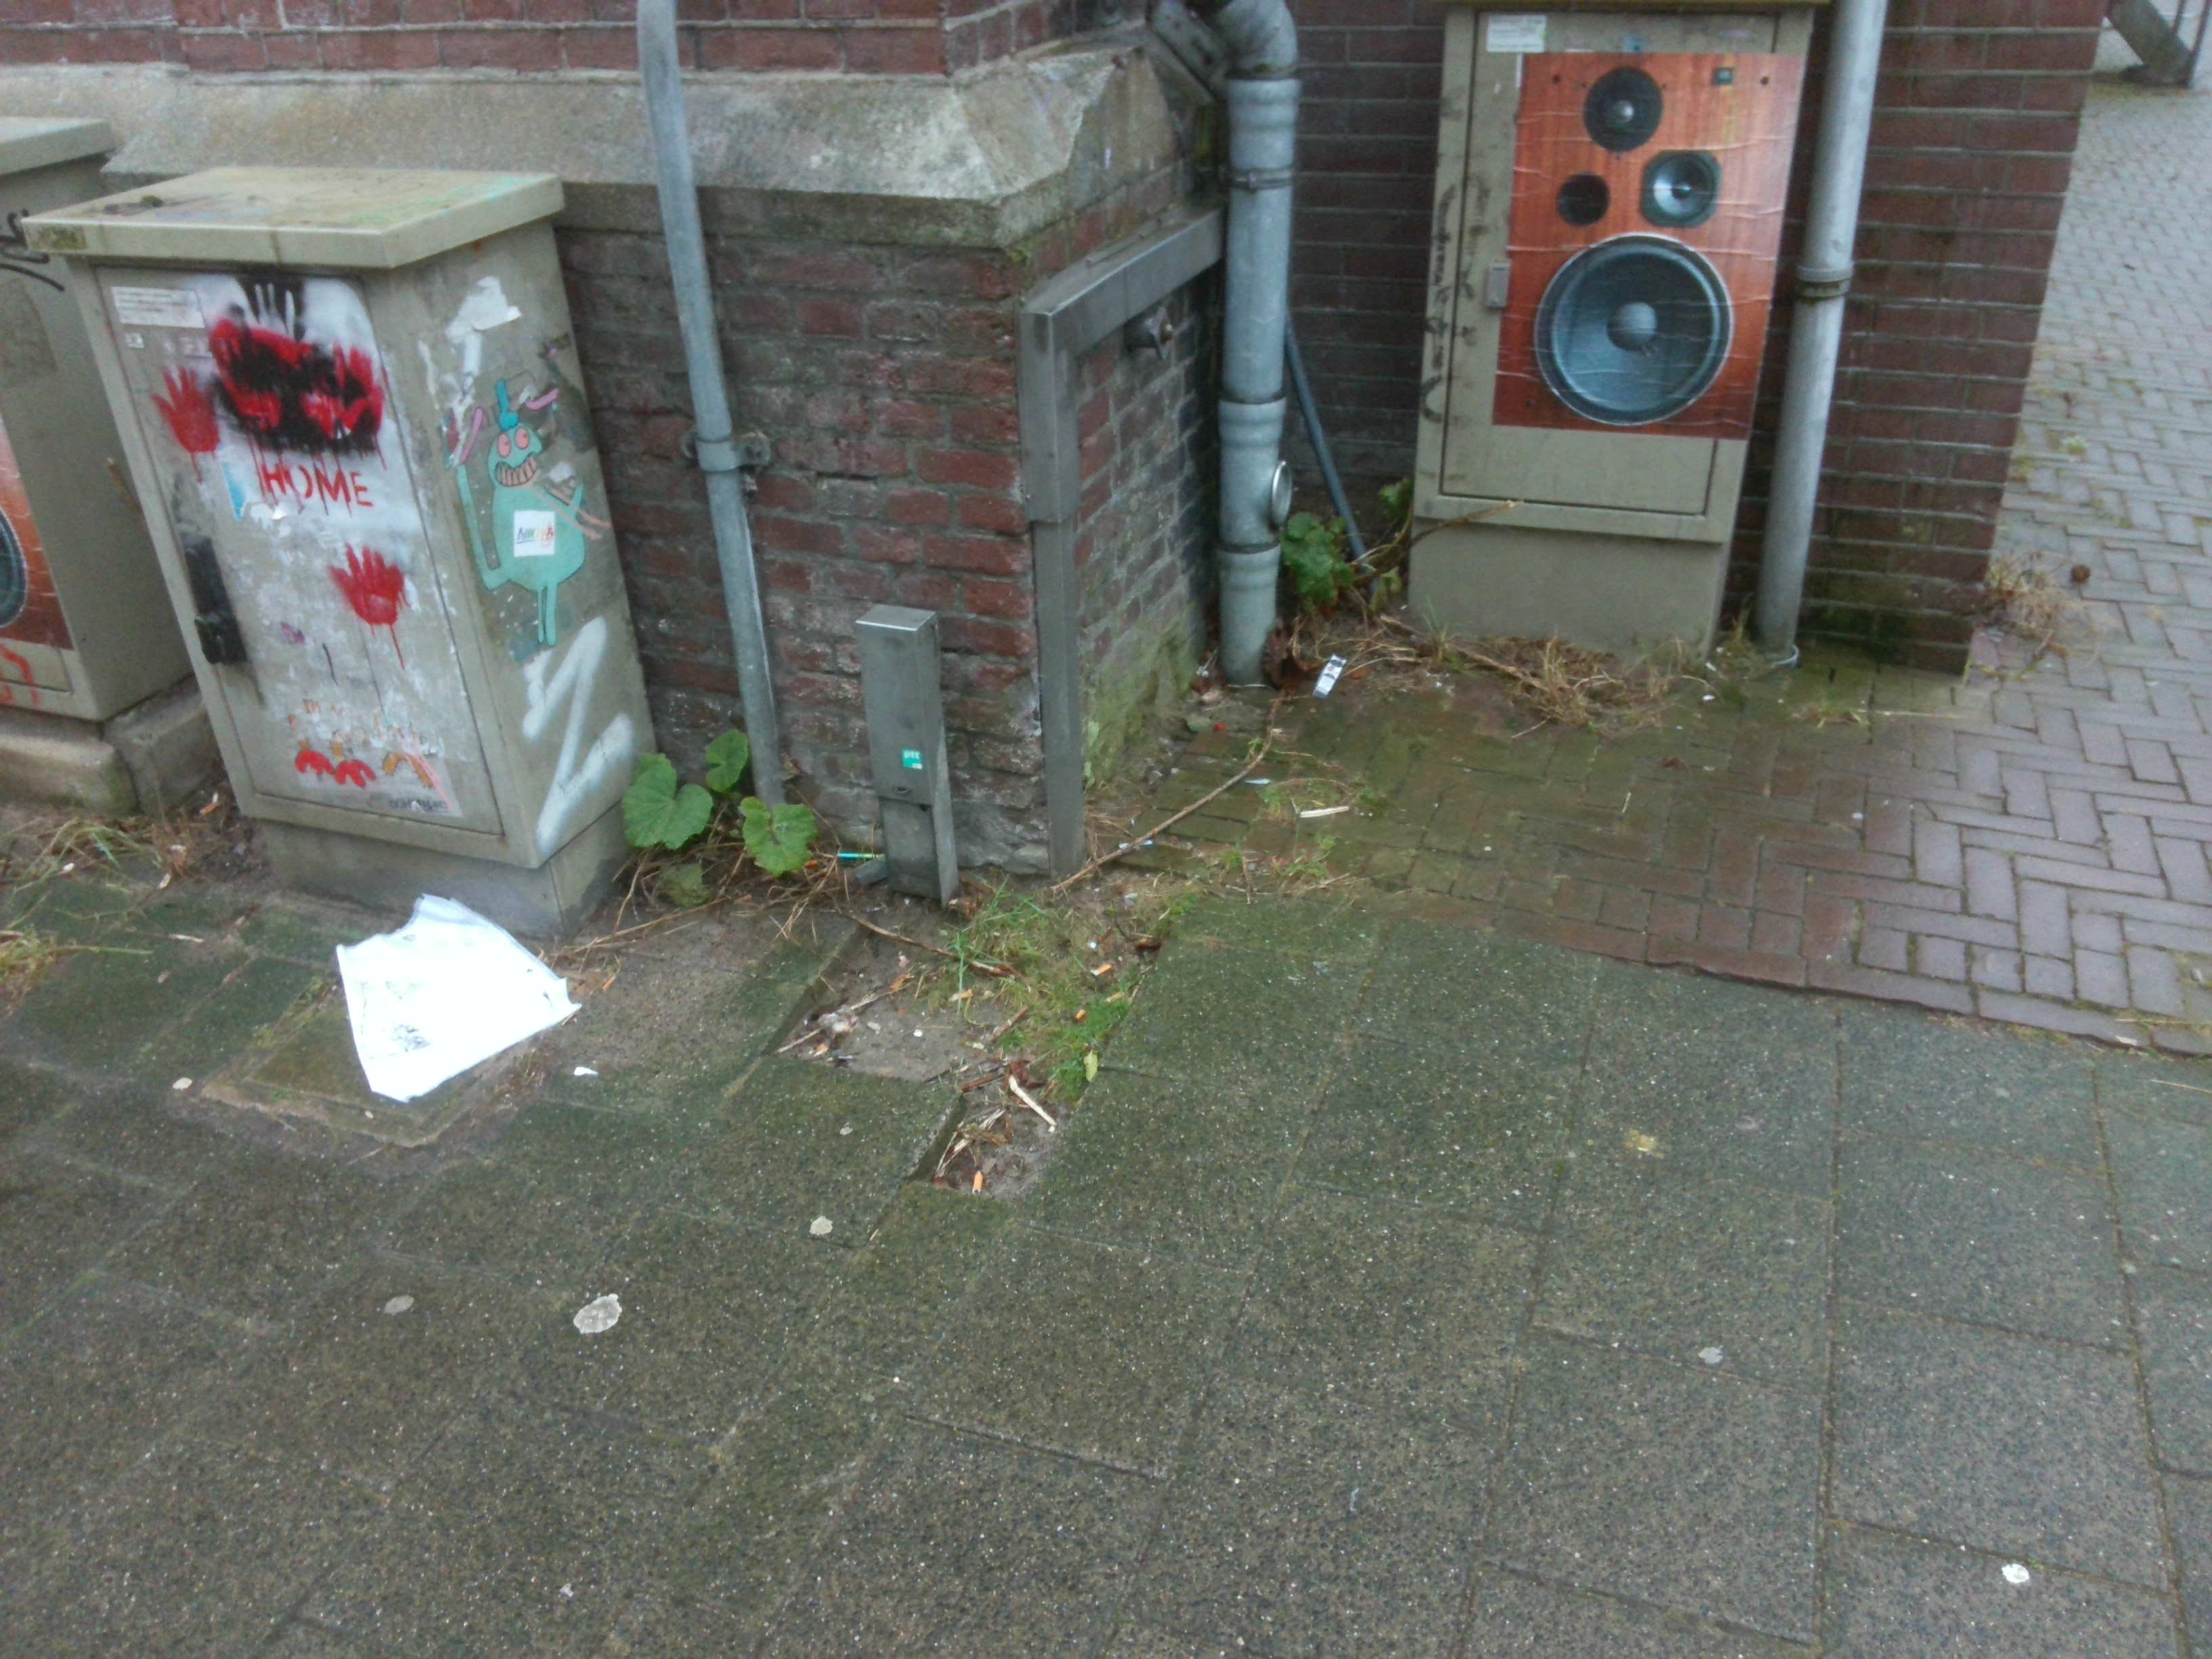

{
  "first_pass": {
    "category1": "missing elements",
    "category2": "loose elements",
    "description": "The sidewalk has visible gaps where paving elements are missing, particularly near the utility boxes and wall. This creates an uneven surface and potential tripping hazards.",
    "reasoning_steps": "I observed that there are clear voids in the sidewalk where tiles or paving elements should be. These gaps are near utility boxes, which could indicate prior maintenance work that was not properly restored. The second possibility is loose elements, as some tiles may have shifted or been removed."
  },
  "used_rag": true,
  "rag_ctx:": {
    "query_image": "local_data/local_test/4ac01480-a566-48cc-a806-737f291f6c90.jpeg",
    "proposed_grade": "D",
    "fused_scores": {
      "A": 0.41940679072853454,
      "A+": 0.0,
      "B": 0.46199164740020005,
      "C": 0.5632901862556263,
      "D": 0.9999880373829833
    },
    "example_images": [
      {
        "grade": "D",
        "pa

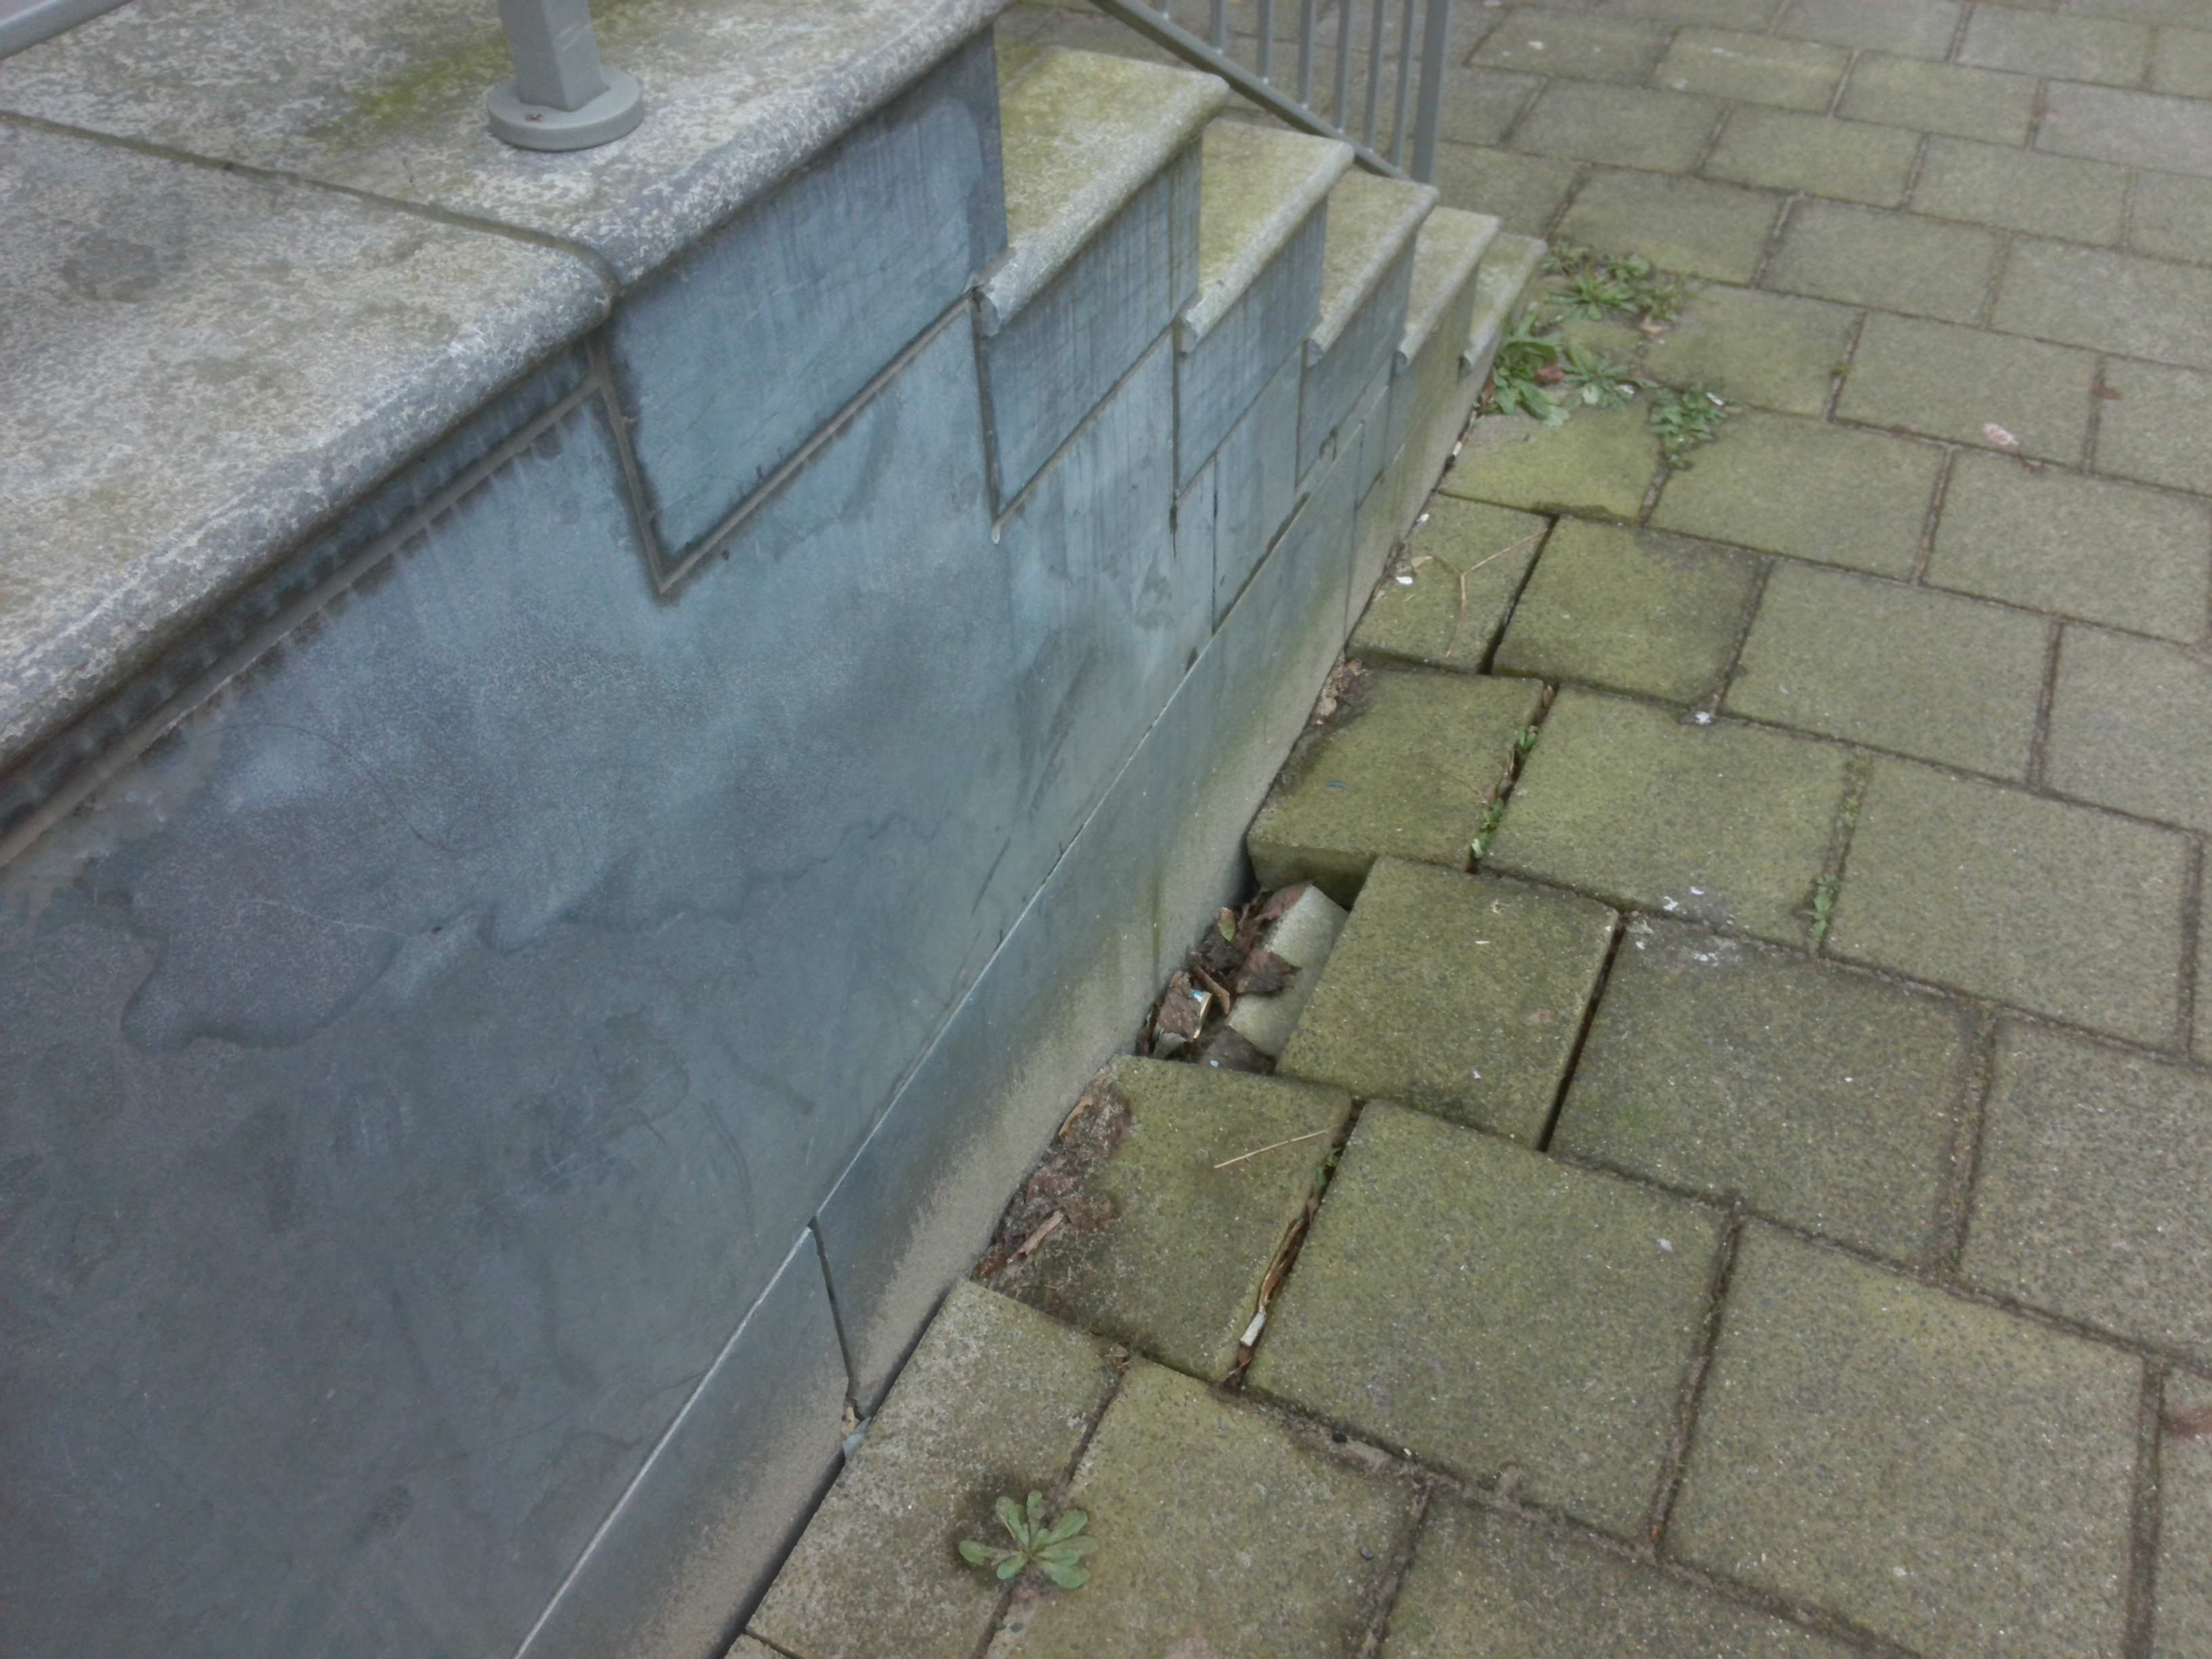

{
  "first_pass": {
    "category1": "local subsidence",
    "category2": "loose elements",
    "description": "The sidewalk shows unevenness and sinking of tiles near the edge of the stairs, likely caused by local subsidence. Some tiles appear to be displaced or loose, creating a potential tripping hazard.",
    "reasoning_steps": "The image shows a clear depression and misalignment of tiles near the stairs. This suggests local subsidence due to soil movement or insufficient support underneath. Loose elements are also a possibility as some tiles seem to be dislodged."
  },
  "used_rag": false,
  "rag_ctx:": null,
  "second_pass": {
    "grade": "C",
    "rationale": "The sidewalk exhibits significant unevenness and sinking of tiles near the stairs, likely due to local subsidence. The displaced and loose tiles create a clear tripping hazard, which poses a safety risk. While the damage is localized and not widespread, the severity of the hazard warrants a grade of C."
  }
}


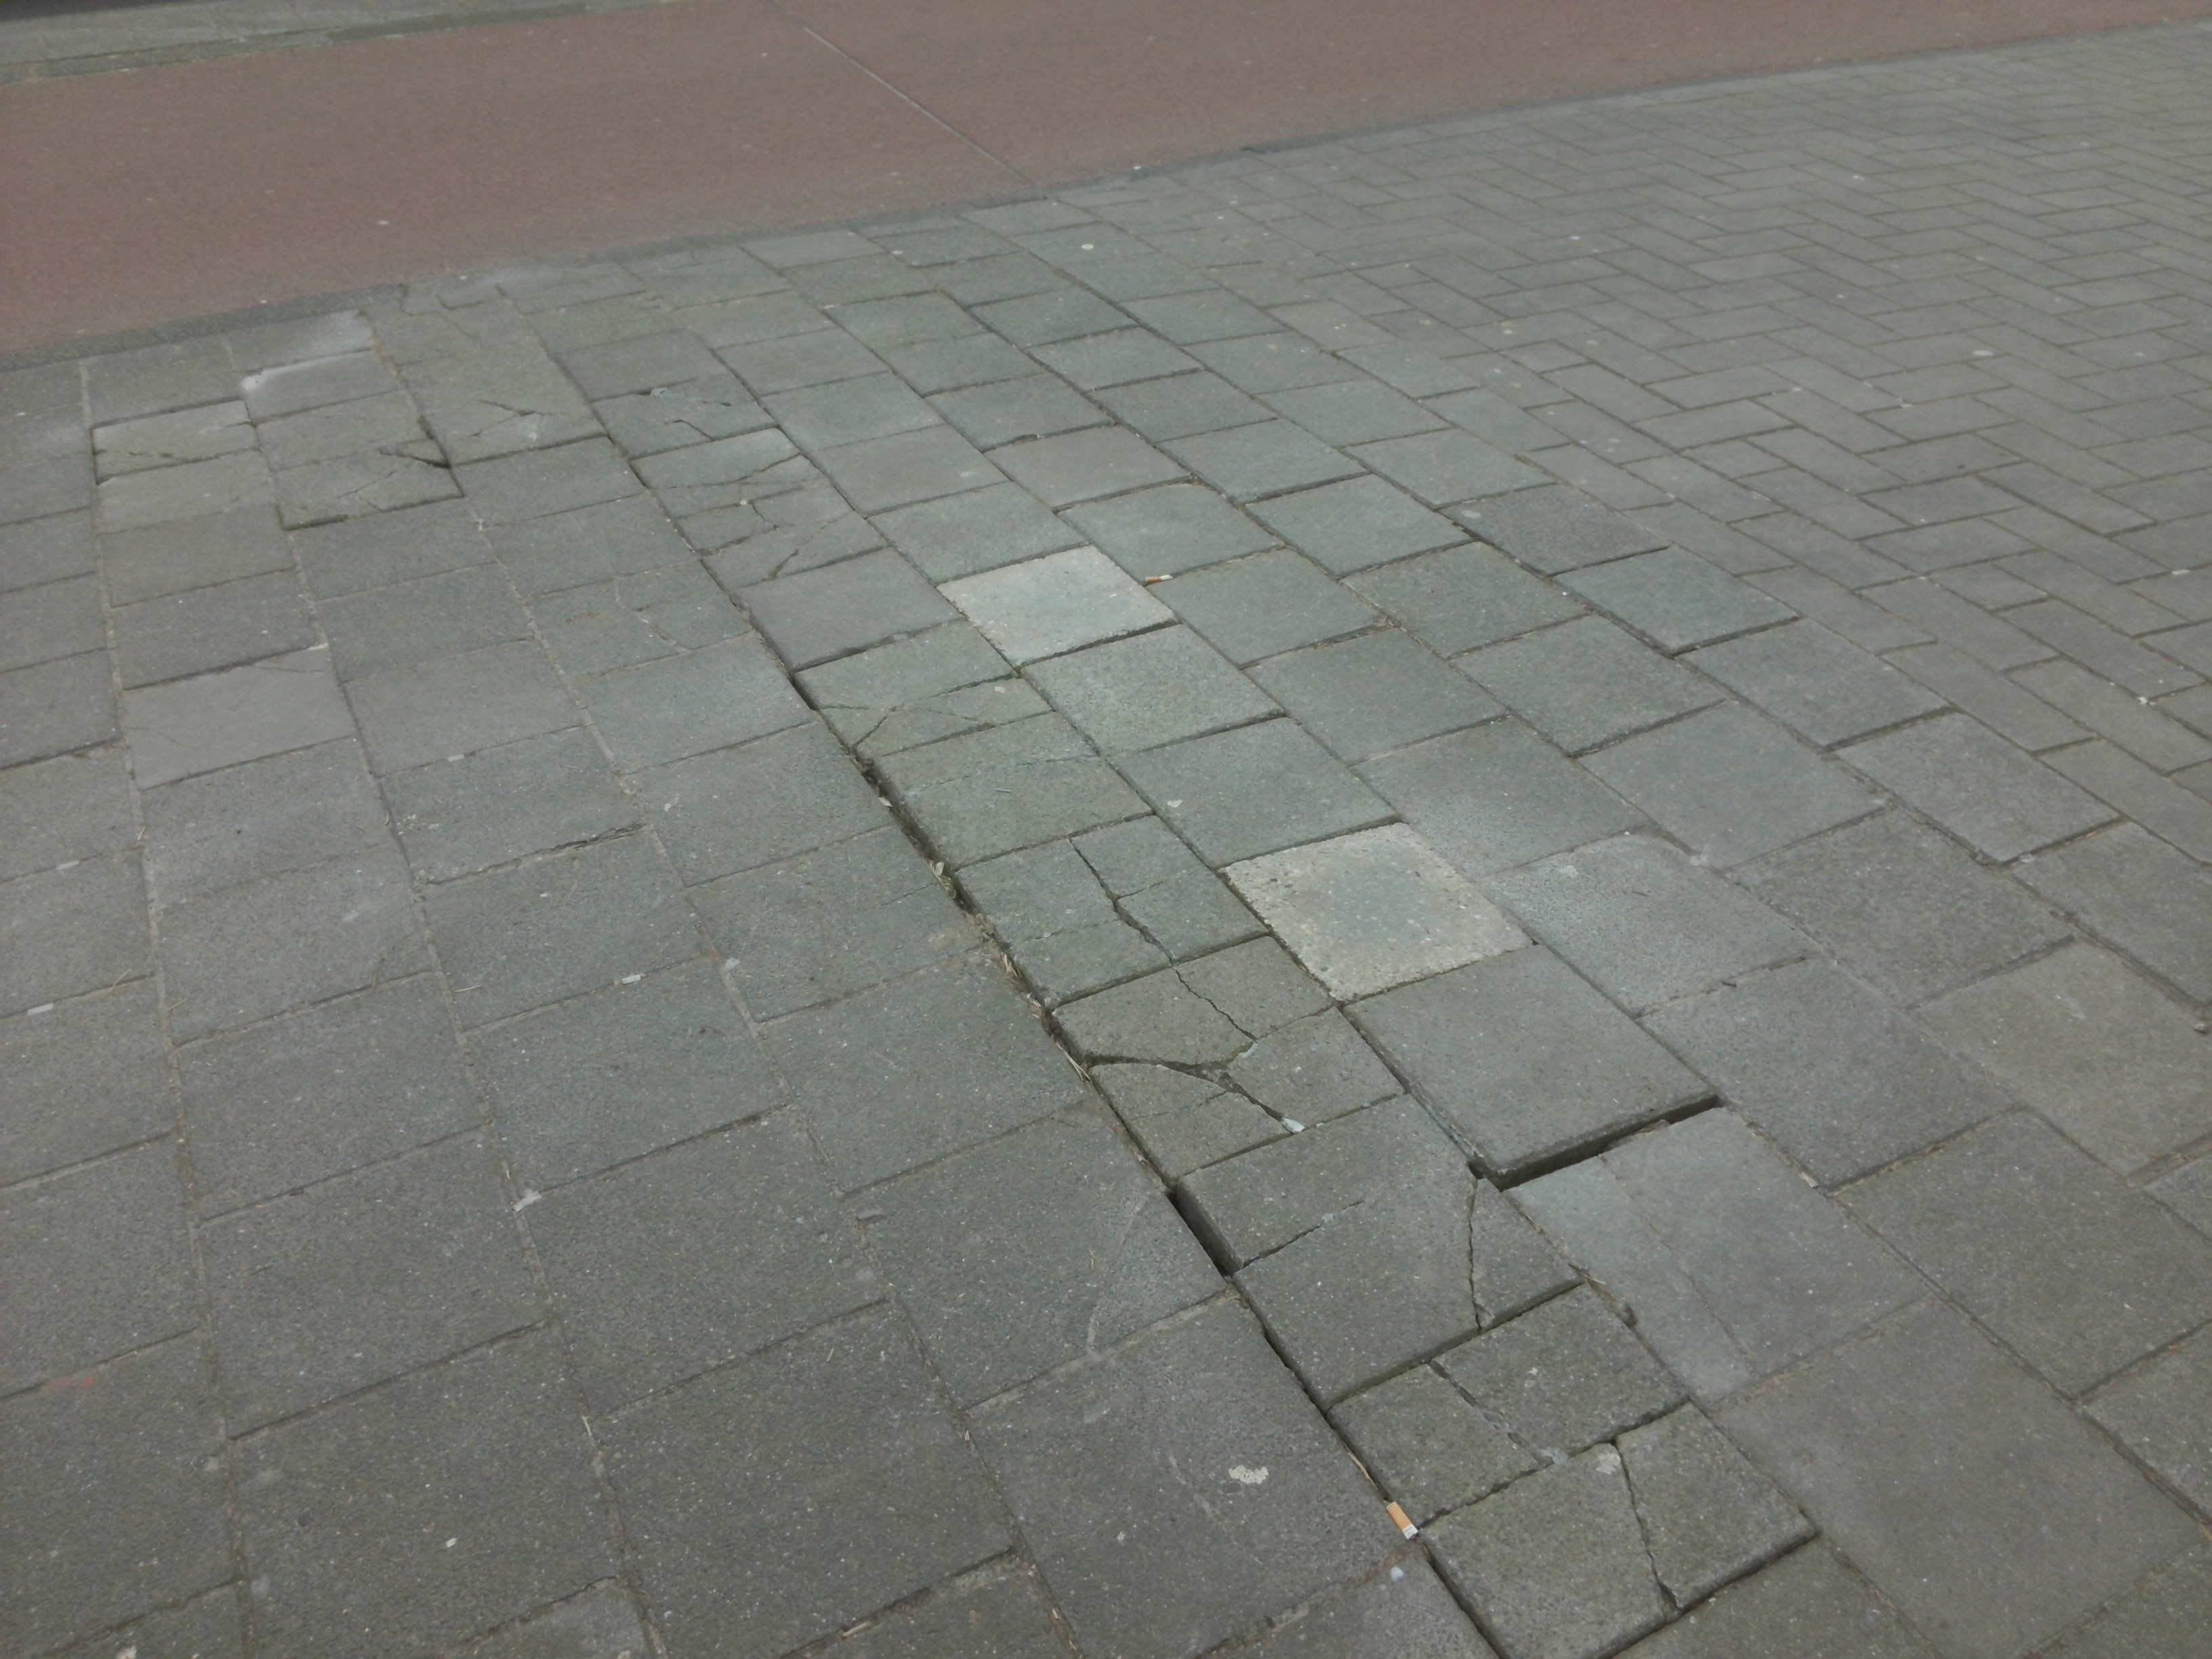

{
  "first_pass": {
    "category1": "local raise",
    "category2": "tree root damage",
    "description": "The sidewalk shows uneven surfaces with raised tiles and visible cracks, likely caused by underlying forces such as tree roots or ground movement.",
    "reasoning_steps": "The image shows a section of the sidewalk where tiles are raised and misaligned. This suggests local raise, possibly due to tree roots or subsurface pressure. The presence of cracks and unevenness supports this assessment. Tree root damage is a secondary possibility given the common association with such patterns."
  },
  "used_rag": false,
  "rag_ctx:": null,
  "second_pass": {
    "grade": "C",
    "rationale": "The sidewalk exhibits significant unevenness with raised tiles and visible cracks, which pose a moderate tripping hazard. The damage is localized but severe enough to impact pedestrian safety and usability. The issues appear to be caused by tree root intrusion or subsurface pressure, as indicated by

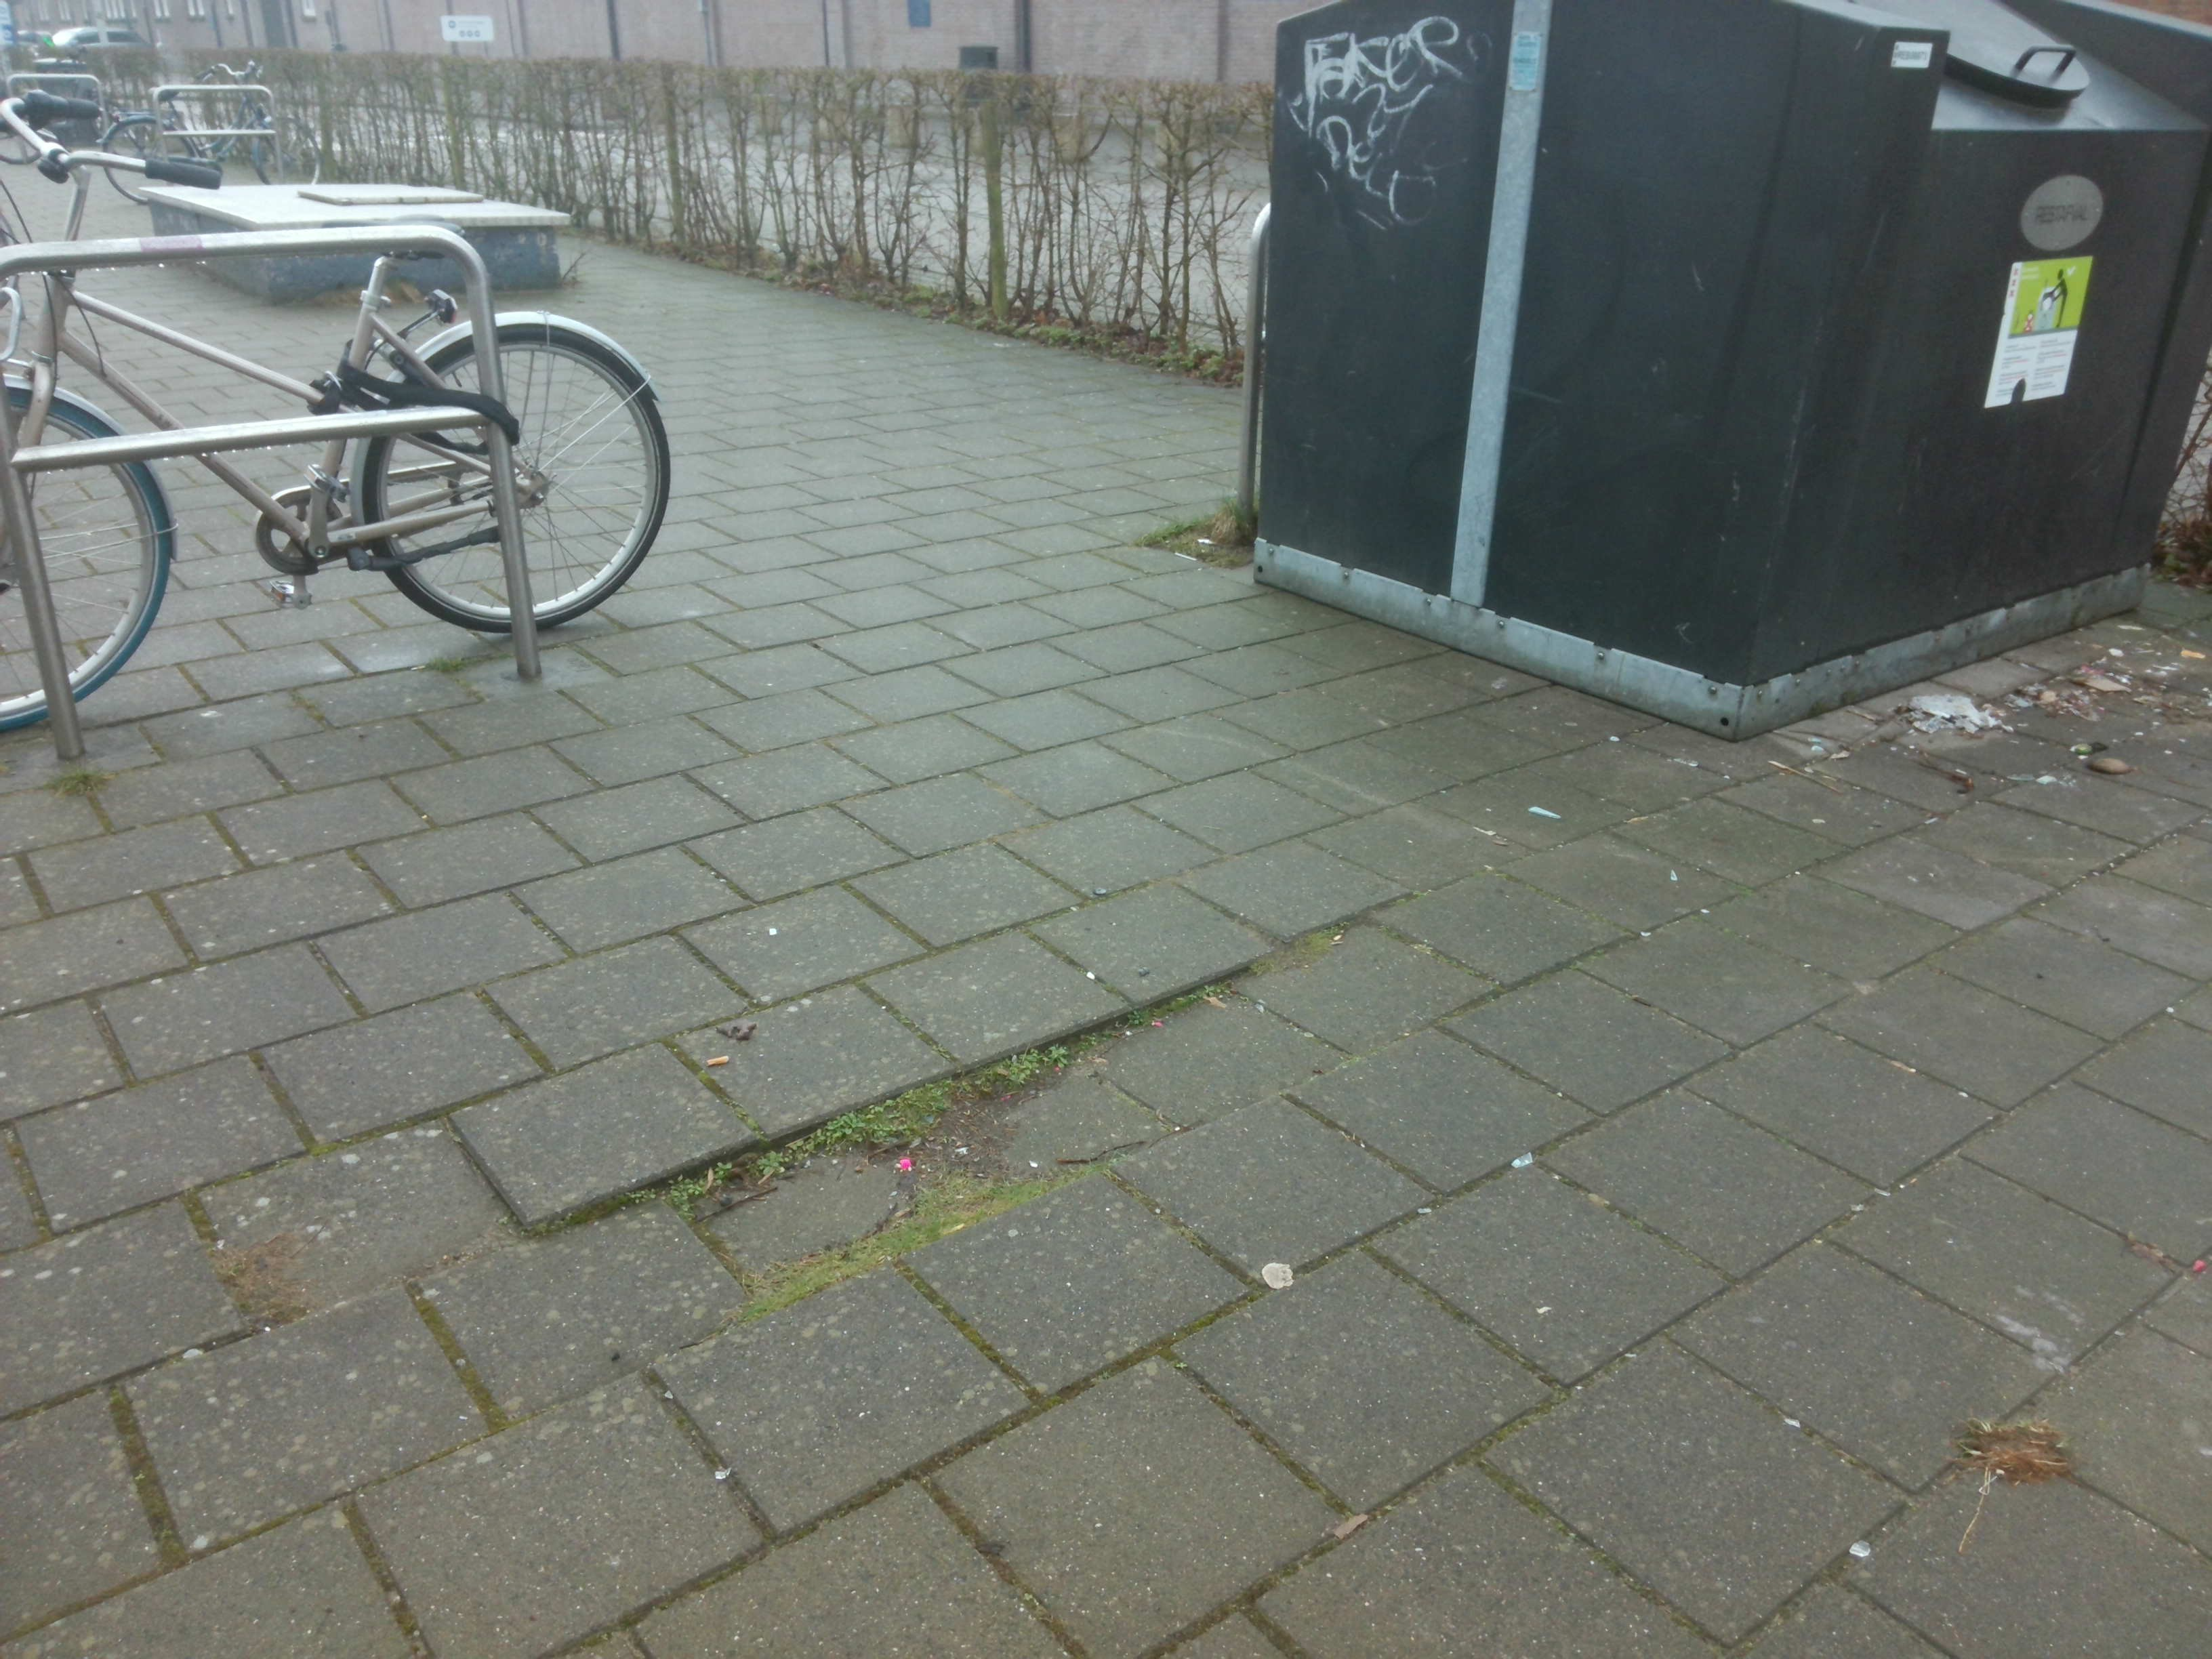

{
  "first_pass": {
    "category1": "local raise",
    "category2": "loose elements",
    "description": "The sidewalk shows uneven tiles with some raised elements, likely caused by underlying pressure or displacement. This creates a tripping hazard and indicates a need for leveling or resetting the tiles.",
    "reasoning_steps": "I observed that some tiles are visibly raised above the surrounding surface, which suggests local raise. The possibility of loose elements was considered as a secondary option since the tiles may have shifted or become unstable."
  },
  "used_rag": false,
  "rag_ctx:": null,
  "second_pass": {
    "grade": "C",
    "rationale": "The sidewalk exhibits uneven tiles with noticeable local raises and gaps between tiles, creating a tripping hazard. While the damage is not widespread, the raised elements and loose tiles significantly impact pedestrian safety and require repair to prevent accidents."
  }
}


In [10]:
images_to_check = get_all_files("local_data/local_test/")
#images_to_check = get_all_files("notebooks/local_data/TestDataHackatonVLM/")

for image_path in images_to_check:
    display_image(image_path)
    base64_image = encode_image(image_path)
    result = get_response(base64_image)
    parsed = json.loads(result)
    print(json.dumps(parsed, indent=2, ensure_ascii=False))